In [2]:
#!pip install category_encoders
import category_encoders
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import mimetypes
import seaborn as sns 
import pickle

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, classification_report, auc, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin # to create classes
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score

#! pip install xgboost

from xgboost import XGBClassifier

import warnings

In [3]:
color_list = ['#F8C471','#F1948A', '#7FB3D5', '#D2B4DE', '#A2D9CE']

### Table of contents
[1. Preserving your model](#1.-Preserving-your-model)   
[2. Train your model](#2.-Train-your-model)   
&emsp;[2.1 Let's build the pipeline](#2.1-Let's-build-the-pipeline)   
&emsp;[2.2 Predicting on new observations](#2.2-Predicting-on-new-observations)   
[3. Serialization of the necessary components](#3.-Serialization-of-the-necessary-components)   
&emsp;[3.1 Serializing the columns in the correct order](#3.1-Serializing-the-columns-in-the-correct-order)   
&emsp;[3.2 Serializing the fitted pipeline](#3.2-Serializing-the-fitted-pipeline)   
&emsp;[3.3 Serializing the dtypes of the columns](#3.3-Serializing-the-dtypes-of-the-columns)

# 1. Preserving your model

In this learning unit you will learn how to preserve your model so that the value it generates can be used in a separate process or program than the one in which it was fitted. There are a few different ways to do this but for this specialization we will be using the following tools:

1. [pickle](https://docs.python.org/3/library/pickle.html) from python core
1. [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators) from scikit

This will be our journey:

1. **Train**: We are going to first train a model on the classic titanic dataset. We will use this one because it has categorical and numeric features, and missing values in both types.

2. **Serialize**: Once the model has been trained as part of a pipeline, we will [serialize] https://en.wikipedia.org/wiki/Serialization) it using the [pickle](https://docs.python.org/3/library/pickle.html) package that is found in python's core.

3. **Predict on new data**: After we are confident we can retrieve the pickled model from the disk, we will show how to prepare a brand new observation for prediction with the model.

# 2. Train your model

In [6]:
df = pd.read_csv('data/data_clean.csv').set_index('observation_id')
df.head()

,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,hour,month,day_of_week,period,target
observation_id,,,,,,,,,,,,,,,,
696ca8c4-6934-48d2-8c73-04af064992ce,person and vehicle search,2020-02-01 00:00:00+00:00,False,51.691896,-4.952055,male,over 34,white,misuse of drugs act 1971 (section 23),controlled drugs,dyfed-powys,0,2,Saturday,Late Night,False
b399fbcb-c27e-420b-b5ef-98f501765fc6,person search,2020-02-01 00:00:00+00:00,False,50.785798,0.263758,male,under 18,white,police and criminal evidence act 1984 (section 1),article for use in theft,sussex,0,2,Saturday,Late Night,False
29b57000-40bf-458f-91fd-35f7c292f5e7,person search,2020-02-01 00:00:00+00:00,False,50.784128,0.291258,male,under 18,white,police and criminal evidence act 1984 (section 1),article for use in theft,sussex,0,2,Saturday,Late Night,False
2ccc1515-e2ed-45c4-a810-8e72f93cde50,person and vehicle search,2020-02-01 00:00:00+00:00,False,50.846339,0.469754,male,under 18,white,police and criminal evidence act 1984 (section 1),article for use in theft,sussex,0,2,Saturday,Late Night,False
72853059-43dd-4594-8183-21c4cb68ca2a,person search,2020-02-01 00:00:00+00:00,False,54.853138,-6.694079,female,over 34,white,misuse of drugs act 1971 (section 23),controlled drugs,sussex,0,2,Saturday,Late Night,False


In [7]:
features =  ['Type',
             'Part of a policing operation',
             'Latitude',
             'Longitude', 
             'Gender', 
             'Age range', 
             'Officer-defined ethnicity', 
             'Legislation', 
             'Object of search', 
             'station',
             'hour', 
             'month', 
             'day_of_week',
             'period']

#### Train/Validation Split

In [11]:
X_train = df[features]
y_train = df['target']

In [12]:
df_test = pd.read_csv('data/data_test_clean.csv',  
                      index_col='observation_id')

In [13]:
X_val = df_test[features]
y_val = df_test['target']

#### Creating the Pipeline

In [14]:
numerical_columns = ['Latitude', 
                     'Longitude', 
                     'hour', 
                     'month']
categorical_columns = [#'day_of_week',
                       #'period'
                      ]
categorical_oe_columns = [
                          'Part of a policing operation',
                          'Type', 
                          #'Gender', 
                          #'Age range', 
                          #'Officer-defined ethnicity', 
                          'Legislation', 
                          'Object of search',    
                          'station',
                          'day_of_week', 
                          'period',
                         ]

In [15]:
num_transformer = Pipeline(steps=[
    ('fillna', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

In [16]:
cat_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[[ 'Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
                                           #['Late Night', 'Early Morning', 'Morning', 'Noon', 'Evening', 'Night']
                                          ], 
                               handle_unknown='use_encoded_value',
                               unknown_value = -1))
])

In [17]:
cat_transformer_oh = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_transformer, numerical_columns),
    ('cat', cat_transformer, categorical_columns),
    ('cat_oh', cat_transformer_oh, categorical_oe_columns)
    ]
)

In [19]:
pipeline_lr = Pipeline([("preprocessor", preprocessor),
                        ('classifier_LogisticRegression', LogisticRegression(solver='liblinear', random_state=42))])

pipeline_rf = Pipeline([("preprocessor", preprocessor),
                        ('classifier_RandomForest', RandomForestClassifier(random_state=42,
                                                   n_estimators = 500,
                                                   min_samples_split = 1575,
                                                   min_samples_leaf = 100,
                                                   max_depth = 10,
                                                   max_features = 19))])

pipeline_gb = make_pipeline(preprocessor,
                        GradientBoostingClassifier(random_state=42,
                                                   n_estimators = 500,
                                                   learning_rate = 0.1,
                                                   min_samples_split = 1575,
                                                   min_samples_leaf = 100,
                                                   max_depth = 10,
                                                   max_features = 19,
                                                   subsample=0.8),)

pipeline_xgb = make_pipeline(preprocessor,
                             XGBClassifier(learning_rate = 0.1,
                                           n_estimators = 250,
                                           max_depth= 9, 
                                           min_child_weight = 1,
                                           gamma = 0,
                                           subsample = 0.8,
                                           colsample_bytree = 0.8,
                                           objective= 'binary:logistic', 
                                           nthread = -1, 
                                           scale_pos_weight = 1,
                                           reg_alpha = 1e-5,
                                           seed=42))

pipelines = [pipeline_lr, 
             pipeline_rf, 
             pipeline_gb, 
             pipeline_xgb]
pipe_dict = {0: 'Logistic Regression', 1:'Random Forest', 2: 'Gradient Boosting', 3: 'XGB Classifier'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

Logistic Regression
ROC_AUC:	 0.6038256316331178
Threshold:	 0.1939869042235219
Precision:	 0.25
Recall:		 0.7848970251716247


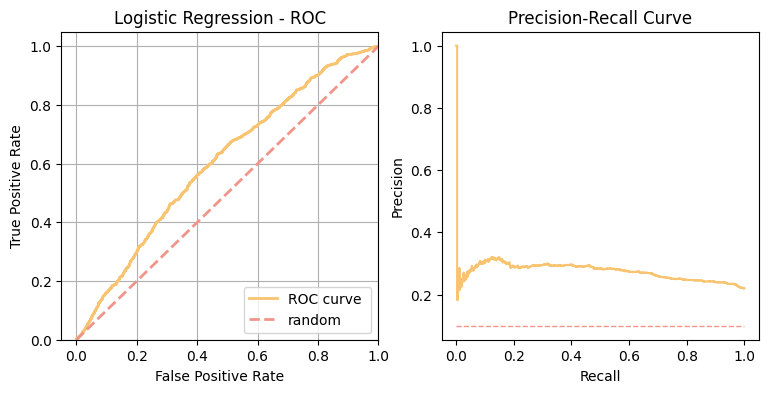

Random Forest
ROC_AUC:	 0.6152573968092225
Threshold:	 0.1880078869873706
Precision:	 0.25
Recall:		 0.8375286041189931


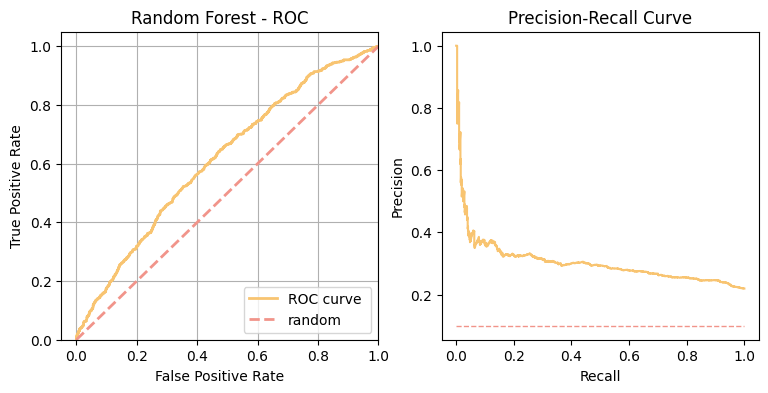

Gradient Boosting
ROC_AUC:	 0.6201969603136608
Threshold:	 0.12541955931903664
Precision:	 0.25
Recall:		 0.88558352402746


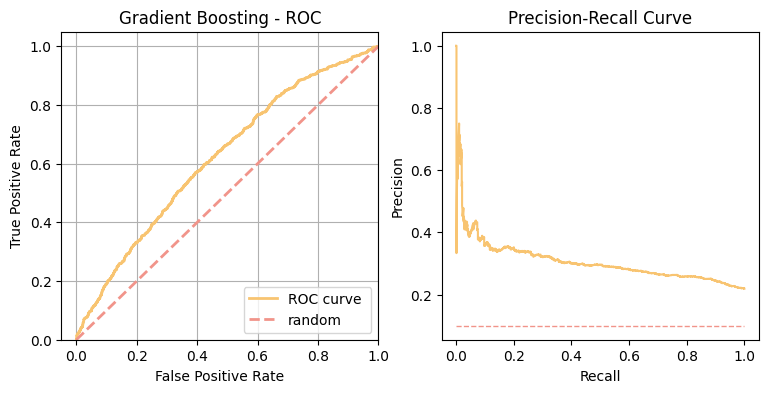

XGB Classifier
ROC_AUC:	 0.6187843231127138
Threshold:	 0.13194668
Precision:	 0.25
Recall:		 0.8695652173913043


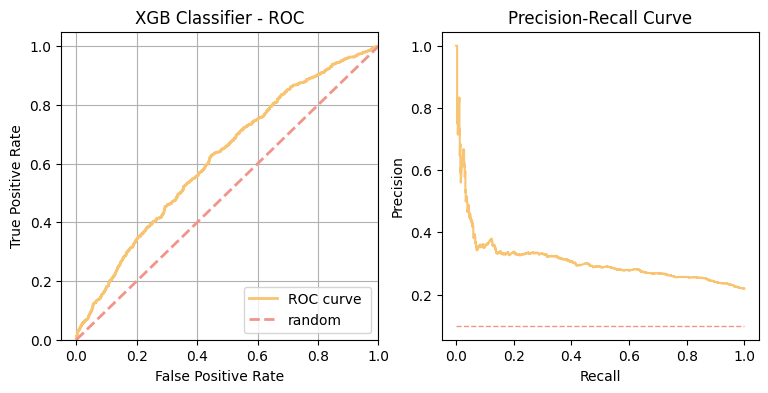


----------------------------------------------------------
Classifier with the best ROC-AUC: Gradient Boosting Classifier



In [76]:
best_roc_auc = 0.0
best_classifier = 0
best_pipeline = ''
prediction_dict={}

for i, model in enumerate (pipelines) : 
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    
    fpr, tpr, threshold = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

    print(pipe_dict[i])
    print("ROC_AUC:\t", roc_auc)
    prediction_dict[pipe_dict[i]]=[y_proba, roc_auc]

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_pipeline = model
        best_classifier = i   
    
    min_index = [i for i, prec in enumerate(precision) if prec >= 0.25][0]
    print("Threshold:\t" , thresholds[min_index])
    print("Precision:\t" ,precision[min_index])
    print("Recall:\t\t", recall[min_index])

    y_model_val = pd.DataFrame(y_val)
    y_model_val.to_csv('data/y_model_val.csv')
    y_model_proba = pd.DataFrame(y_proba)
    y_model_proba.to_csv('data/y_model_proba.csv')
    
    #create Plot
    fig = plt.figure(figsize=(9,4))    
 
    axes = fig.add_subplot(1,2,1)
    axes = plt.plot(fpr, tpr, color='#F8C471', lw=2, label='ROC curve ')
    axes = plt.plot([0, 1], [0, 1], color = '#F1948A', lw=2, linestyle='--', label='random')
    axes = plt.xlim([-0.05, 1.0])
    axes = plt.ylim([0.0, 1.05])
    axes = plt.grid()
    axes = plt.xlabel('False Positive Rate')
    axes = plt.ylabel('True Positive Rate')
    axes = plt.title("{} - ROC".format(pipe_dict[i]))
    axes = plt.legend(loc="lower right")
    
    axes = fig.add_subplot(1,2,2)
    axes = plt.plot(recall, precision, color='#F8C471')
    axes = plt.hlines(y=0.1, xmin=0, xmax=1, linewidth=1, color = '#F1948A', linestyle="--")
    axes = plt.title('Precision-Recall Curve')
    axes = plt.ylabel('Precision')
    axes = plt.xlabel('Recall')

    plt.show()    
    
print('\n----------------------------------------------------------')
print('Classifier with the best ROC-AUC: {} Classifier\n'.format(pipe_dict[best_classifier]))

In [77]:
#pipeline = pipeline_lr
#pipeline = pipeline_rf
#pipeline = pipeline_gb
pipeline = pipeline_xgb

In [78]:
threshold = thresholds[min_index]
#threshold = 0.22359079294352646
y_threshold = pd.Series([True if p >= threshold else False for p in y_proba]).to_numpy()

In [79]:
threshold

0.13194668

### Business Requirements Validation

####  Precision higher or equal to 10% per police station and search objective

In [80]:
def CalculatePrecision(y_true, y_pred, threshold = 0.1):
    
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    threshold_fulfilled = (precision >= threshold)
    
    return precision, recall, threshold_fulfilled

In [81]:
precision, recall, threshold_fulfilled = CalculatePrecision(y_val, y_threshold)

print("Global Precision: {}".format((threshold_fulfilled, precision)))
print("Global Recall: {}".format(recall))

Global Precision: (True, 0.25)
Global Recall: 0.8695652173913043


In [82]:
def verify_precision_per_station_object(X_test, y_true, y_pred, sensitive_column='Object of search', min_precision=0.1, min_samples=50):
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)

        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff < min_precision:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
            
    station_precisions = {}
    for department in departments:
        mask = (X_test['station'] == department)
        if np.sum(mask) > min_samples:
            station_precisions[department] = precision_score(y_true[mask], y_pred[mask])
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff < min_precision:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions, station_precisions

In [96]:
warnings.filterwarnings('ignore')

is_satisfied, problematic_departments, good_deparments, global_precisions, station_precisions = verify_precision_per_station_object(
    X_val, y_val, y_threshold)


print("Object of search")

#if not is_satisfied:
print("Requirement failed 😢")
print("Global rates: {}".format(global_precisions))
print("Num problematic departments: {}".format(len(problematic_departments)))
print("Num good departments: {}".format(len(good_deparments)))
print("avg diff:", np.mean([p[1] for p in problematic_departments]))
print("\nStation rates: {}".format(station_precisions))
print('Maximum diference: {}'.format(max(station_precisions.values()) - min(station_precisions.values())))
print('Stations that fulfill: {}'.format(np.sum([1 for sp in station_precisions.values() if sp >= 0.1 ])))

Object of search
Requirement failed 😢
Global rates: {'offensive weapons': 0.18045112781954886, 'controlled drugs': 0.25611681136543013, 'article for use in theft': 0.26627218934911245, 'stolen goods': 0.21693121693121692}
Num problematic departments: 2
Num good departments: 4
avg diff: 0.05248698939840497

Station rates: {'nottinghamshire': 0.2652027027027027, 'cambridgeshire': 0.3102310231023102, 'city-of-london': 0.24401913875598086, 'devon-and-cornwall': 0.20808383233532934, 'durham': 0.26715686274509803, 'bedfordshire': 0.24423963133640553}
Maximum diference: 0.10214719076698087
Stations that fulfill: 6


In [84]:
X_val.groupby(['station'])['station'].value_counts()

station             station           
bedfordshire        bedfordshire           827
cambridgeshire      cambridgeshire         430
city-of-london      city-of-london         473
devon-and-cornwall  devon-and-cornwall    1091
durham              durham                 421
nottinghamshire     nottinghamshire        758
Name: station, dtype: int64

In [85]:
problematic_departments

[('devon-and-cornwall',
  0.07800897592819259,
  {'offensive weapons': 0.13953488372093023,
   'controlled drugs': 0.21754385964912282,
   'stolen goods': 0.14}),
 ('durham',
  0.02696500286861736,
  {'offensive weapons': 0.23809523809523808,
   'controlled drugs': 0.25980392156862747,
   'article for use in theft': 0.26506024096385544})]

In [86]:
good_deparments

[('nottinghamshire',
  0.1586730615507594,
  {'offensive weapons': 0.1111111111111111,
   'controlled drugs': 0.2697841726618705}),
 ('cambridgeshire',
  0.3184931506849315,
  {'offensive weapons': 0.0,
   'controlled drugs': 0.3184931506849315,
   'article for use in theft': 0.0}),
 ('city-of-london',
  0.13206477222607269,
  {'controlled drugs': 0.26765799256505574,
   'article for use in theft': 0.26582278481012656,
   'stolen goods': 0.13559322033898305}),
 ('bedfordshire',
  0.24416796267496113,
  {'offensive weapons': 0.0,
   'controlled drugs': 0.24416796267496113,
   'article for use in theft': 0.0})]

#### Discrepancy lower than 5% per police station between the success rate of protected classes (ethnicity, gender)

In [97]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Officer-defined ethnicity', max_diff=0.05, min_samples=50):
    """
    Verifies that no department has discrimination in between protected races
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions



In [98]:
warnings.filterwarnings('ignore')

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_val, y_val, y_threshold)


print("Officer-defined Ethnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))    

Officer-defined Ethnicity
Requirement failed 😢
Global rates: {'black': 0.2222222222222222, 'asian': 0.27002967359050445, 'white': 0.25101397025687244, 'other': 0.26865671641791045, 'mixed': 0.2564102564102564}
Num problematic departments: 3
Num good departments: 0
avg diff: 0.07986045027243531


In [99]:
problematic_departments

[('nottinghamshire',
  0.05840455840455844,
  {'black': 0.2777777777777778,
   'asian': 0.3148148148148148,
   'white': 0.25692695214105793,
   'mixed': 0.2564102564102564}),
 ('city-of-london',
  0.06441947565543071,
  {'black': 0.20224719101123595,
   'asian': 0.25,
   'white': 0.2549019607843137,
   'other': 0.26666666666666666}),
 ('bedfordshire',
  0.11675731675731676,
  {'black': 0.16296296296296298,
   'asian': 0.27972027972027974,
   'white': 0.2587601078167116})]

In [100]:
good_deparments

[]

In [104]:
print("\nGender")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_val, y_val, y_threshold, sensitive_column='Gender')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Gender
Requirement failed 😢
Global rates: {'male': 0.2574331953330824, 'female': 0.19553072625698323}
Num problematic departments: 2
Num good departments: 2
avg diff: 0.09436229639017979


In [102]:
problematic_departments

[('cambridgeshire',
  0.1269961977186312,
  {'male': 0.3269961977186312, 'female': 0.2}),
 ('bedfordshire',
  0.06172839506172839,
  {'male': 0.25220458553791886, 'female': 0.19047619047619047})]

In [103]:
good_deparments

[('nottinghamshire',
  0.03421451190967917,
  {'male': 0.2620817843866171, 'female': 0.2962962962962963}),
 ('devon-and-cornwall',
  0.044788732394366176,
  {'male': 0.2147887323943662, 'female': 0.17})]

In [94]:
print("\n\nAge Range")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_val, y_val, y_threshold, sensitive_column='Age range')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))    



Age Range
Requirement failed 😢
Global rates: {'18-24': 0.2678762006403415, 'under 18': 0.2033898305084746, 'over 34': 0.22544642857142858, '25-34': 0.28085642317380355}
Num problematic departments: 6
Num good departments: 0
avg diff: 0.1336358851669735
Departments analysed: 6


#### Re-Deployment Analysis

In [106]:
df_test['target'].value_counts(normalize = True)

0    0.7815
1    0.2185
Name: target, dtype: float64

In [109]:
df['target'].value_counts(normalize = True)

False    0.817557
True     0.182443
Name: target, dtype: float64

In [116]:
common_departments = df_test['station'].value_counts().head(20).index
departments_new = df_test[df_test['station'].isin(common_departments)]
departments_old = df[df['station'].isin(common_departments)]

In [117]:
pd.crosstab(departments_new['target'], departments_new['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
target,,,,,,
0,0.789601,0.730233,0.775899,0.822181,0.736342,0.771768
1,0.210399,0.269767,0.224101,0.177819,0.263658,0.228232


In [118]:
pd.crosstab(departments_old['target'], departments_old['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
target,,,,,,
False,0.786924,0.762103,0.747962,0.817348,0.724686,0.76645
True,0.213076,0.237897,0.252038,0.182652,0.275314,0.23355


In [119]:
pd.crosstab(departments_new['Officer-defined ethnicity'], departments_new['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Officer-defined ethnicity,,,,,,
asian,0.205562,0.106977,0.192389,0.023831,0.011876,0.080475
black,0.193470,0.106977,0.228330,0.031164,0.011876,0.147757
mixed,0.000000,0.000000,0.000000,0.000000,0.000000,0.075198
other,0.003628,0.009302,0.114165,0.005500,0.007126,0.021108
white,0.597340,0.776744,0.465116,0.939505,0.969121,0.675462


In [120]:
pd.crosstab(departments_old['Officer-defined ethnicity'], departments_old['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Officer-defined ethnicity,,,,,,
asian,0.292683,0.127413,0.204450,0.012837,0.013947,0.104878
black,0.168022,0.097713,0.235735,0.040895,0.010042,0.124817
mixed,0.000000,0.000000,0.000000,0.000000,0.000000,0.059285
other,0.014228,0.025245,0.074245,0.007519,0.006416,0.013558
white,0.525068,0.749629,0.485570,0.938749,0.969596,0.697461


In [122]:
pd.crosstab(departments_new['Gender'], departments_new['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Gender,,,,,,
female,0.122128,0.123256,0.07611,0.145738,0.111639,0.094987
male,0.877872,0.876744,0.92389,0.854262,0.826603,0.905013
other,0.000000,0.000000,0.00000,0.000000,0.061758,0.000000


In [121]:
pd.crosstab(departments_old['Gender'], departments_old['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Gender,,,,,,
female,0.099593,0.105138,0.09187,0.158812,0.121339,0.088130
male,0.900407,0.894862,0.90813,0.841188,0.821478,0.911073
other,0.000000,0.000000,0.00000,0.000000,0.057183,0.000798


In [124]:
pd.crosstab(departments_new['Type'], departments_new['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Type,,,,,,
person and vehicle search,0.230955,0.218605,0.217759,0.132906,0.266033,0.229551
person search,0.769045,0.781395,0.782241,0.867094,0.733967,0.770449


In [123]:
pd.crosstab(departments_old['Type'], departments_old['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Type,,,,,,
person and vehicle search,0.238144,0.16929,0.263274,0.167339,0.285356,0.203243
person search,0.761856,0.83071,0.736726,0.832661,0.714644,0.796757


In [125]:
pd.crosstab(departments_new['Legislation'], departments_new['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Legislation,,,,,,
criminal justice and public order act 1994 (section 60),0.000000,0.00000,0.000000,0.000000,0.000000,0.010554
firearms act 1968 (section 47),0.001209,0.00000,0.002114,0.000917,0.007126,0.001319
misuse of drugs act 1971 (section 23),0.777509,0.67907,0.568710,0.746104,0.484561,0.733509
other,0.001209,0.00000,0.000000,0.000000,0.011876,0.034301
police and criminal evidence act 1984 (section 1),0.220073,0.32093,0.429175,0.252979,0.496437,0.220317


In [126]:
pd.crosstab(departments_old['Legislation'], departments_old['station'], normalize="columns")

station,bedfordshire,cambridgeshire,city-of-london,devon-and-cornwall,durham,nottinghamshire
Legislation,,,,,,
criminal justice and public order act 1994 (section 60),0.000000,0.000594,0.000000,0.000092,0.000279,0.002260
firearms act 1968 (section 47),0.003896,0.002376,0.007491,0.002109,0.002789,0.004254
misuse of drugs act 1971 (section 23),0.743733,0.704188,0.615995,0.737301,0.546722,0.766715
other,0.003388,0.000297,0.000220,0.000000,0.013110,0.024857
police and criminal evidence act 1984 (section 1),0.248984,0.290466,0.376294,0.260499,0.437099,0.201781
unknown,0.000000,0.002079,0.000000,0.000000,0.000000,0.000133
